In [128]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression
import scipy.stats

import yfinance as yfin
yfin.pdr_override()
from var import VaR

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,6)

# 0. Weekly Tasks
Prepare a presentation using Panopto (PowerPoint slides with Video Narration is an acceptable alternative) addressing the following points:
What scenario were you assigned as the result of the random number exercise?

- What were your considerations in determining an appropriate investment strategy for that scenario?

- What asset allocation did you implement that you felt best supported that investment strategy?

- What assets did you invest in consistent with that asset allocation and strategy? (Assets, Price at time of investment, % of total investment)

- Present Value, Profit/Loss to date, VaR, SHARPE, VWAP, Alpha (Other metrics that you feel important in support of your strategy) for your portfolio 

What reallocation of assets would you recommend at this time (if any) and why?
Post your presentation accessible to your colleagues for comment and comment on the presentations by your colleagues.

# 1. Variables

In [129]:
start_date = datetime(2022, 1, 1)
purchase_date = datetime(2023, 9, 11)
purchase_date_str = '2023-9-11'
end_date = datetime.now()
start = datetime(2023, 12, 8)
end = datetime(2023, 12, 9)
end_date_str = end_date.strftime("%Y-%m-%d")

alpha = 0.05
period = '5y'

# 2. Functions

# 3. Load Data

## 3.1 Load Variables

In [130]:
var_lst = ['^TNX']
data = pdr.get_data_yahoo(var_lst, start=start_date, end=purchase_date )['Close']
rf_rate = round((data.mean()),4)
rf_rate

[*********************100%%**********************]  1 of 1 completed


3.2779

In [131]:
var_lst = ['GSPCX']
bench_df = pdr.get_data_yahoo(var_lst, start=start_date, end=purchase_date)['Close']
bench_econ_df = pd.DataFrame(bench_df)
bench_econ_df.columns = ['GSPCX']

benchPercent_econ_df = bench_econ_df.pct_change()[1:]
benchPercent_econ_df.reset_index(inplace=True)
benchPercent_econ_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,GSPCX
0,2022-01-04,-0.0018
1,2022-01-05,-0.0217
2,2022-01-06,-0.0012
3,2022-01-07,-0.0048
4,2022-01-10,-0.0030


In [132]:
var_lst = ['AGG']
bench_df = pdr.get_data_yahoo(var_lst, start=start_date, end=purchase_date)['Close']
bench_int_df = pd.DataFrame(bench_df)
bench_int_df.columns = ['AGG']

benchPercent_int_df = bench_int_df.pct_change()[1:]
benchPercent_int_df.reset_index(inplace=True)
benchPercent_int_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,AGG
0,2022-01-04,-0.0001
1,2022-01-05,-0.0031
2,2022-01-06,-0.0011
3,2022-01-07,-0.0029
4,2022-01-10,-0.0009


## 3.2 Load Portfolio

In [133]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w15/data/DATA618_Portfolio_Full.csv', 
                 parse_dates =['Date'],
                 dtype={
                    'ID': 'int',
                    'Value': 'float', 
                 })


# Class Portfolios
folio_econ_df = folio_df[folio_df['Class'] == 'Economically Sensitive']
folio_int_df = folio_df[folio_df['Class'] == 'Interest Rate Sensitive']

folio_df

,Unnamed: 0,Ticker,BondName,Morningstar_Category,Class,Sub_Class,Date,Value
0,0,IVV,iShares Core S&P 500 ETF,Large Blend,Economically Sensitive,U.S. Equities,2023-09-11,"4,000.0000"
1,1,VONG,Vanguard Russell 1000 Growth ETF,Large Growth,Economically Sensitive,U.S. Equities,2023-09-11,"3,000.0000"
2,2,SCHD,Schwab US Dividend Equity ETF™,Large Value,Economically Sensitive,U.S. Equities,2023-09-11,"3,000.0000"
3,3,IMCB,iShares Morningstar Mid-Cap ETF,Mid-Cap Blend,Economically Sensitive,U.S. Equities,2023-09-11,"4,000.0000"
4,4,VO,Vanguard Mid-Cap ETF,Mid-Cap Blend,Economically Sensitive,U.S. Equities,2023-09-11,"2,000.0000"
...,...,...,...,...,...,...,...,...
35,40,ARKK,ARK Innovation ETF,Mid-Cap Blend,Economically Sensitive,U.S. Equities,2023-10-13,"1,000.0000"
36,41,EXAS,Exact Sciences Corp,Mid-Cap Blend,Economically Sensitive,U.S. Equities,2023-10-13,500.0000
37,42,NVTA,Invitae Corp,Mid-Cap Blend,Economically Sensitive,U.S. Equities,2023-10-13,500.0000
38,43,PATH,UiPath Inc Class A,Mid-Cap Blend,Economically Sensitive,U.S. Equities,2023-10-13,500.0000


In [134]:
shares_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w15/data/DATA618_Shares.csv', 
                 parse_dates =['Date'])
shares_df.set_index('Date', inplace=True)
shares_df.dropna(inplace=True)
shares_df

,ALTVX,ARKK,BLUEX,BPLSX,C_A_S_H,DFAR,EXAS,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2023-09-11,106383,0,14201,49967,4182856,108467,0,...,54437,95923,40481,40221,9234,41501,20333
2023-09-12,106383,0,14201,49967,4182856,108467,0,...,54437,95923,40481,40221,9234,41501,20333
2023-09-13,106383,0,14201,49967,4182856,108467,0,...,54437,95923,40481,40221,9234,41501,20333
2023-09-14,106383,0,14201,49967,4182856,108467,0,...,54437,95923,40481,40221,9234,41501,20333
2023-09-15,106383,0,14201,49967,4182856,108467,0,...,54437,95923,40481,40221,9234,41501,20333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,106383,26476,14201,49967,3182856,108467,7660,...,54437,95923,40481,40221,9234,41501,20333
2023-12-05,106383,26476,14201,49967,3182856,108467,7660,...,54437,95923,40481,40221,9234,41501,20333
2023-12-06,106383,26476,14201,49967,3182856,108467,7660,...,54437,95923,40481,40221,9234,41501,20333


In [135]:
var_lst

['AGG']

In [136]:
var_lst = list(shares_df.columns)
price_df = pdr.get_data_yahoo(var_lst, start=start, end=end)['Close']
price_df = pd.DataFrame(price_df)
#price_df.columns = ['AGG']
price_df['C_A_S_H'] = 1

#price_df = price_df.pct_change()[1:]
#price_df.reset_index(inplace=True)
price_df

[*********************100%%**********************]  40 of 40 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No timezone found, symbol may be delisted')


,ALTVX,ARKK,BLUEX,BPLSX,C_A_S_H,DFAR,EXAS,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2023-12-08 00:00:00,9.5800,49.1800,34.8000,15.5400,1,21.6500,64.7200,...,18.7900,21.2700,75.7200,83.6400,221.2500,75.7000,50.3100


In [137]:
shares_df[-1:]

,ALTVX,ARKK,BLUEX,BPLSX,C_A_S_H,DFAR,EXAS,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2023-12-08,106383,26476,14201,49967,3182856,108467,7660,...,54437,95923,40481,40221,9234,41501,20333


In [138]:
totalValue_df = shares_df[-1:] * price_df
totalValue_df = totalValue_df.T.copy()
totalValue_df.reset_index(inplace=True)
totalValue_df.columns = ['Ticker','Value']
totalValue_df['port_percent'] = round(totalValue_df['Value'] / totalValue_df['Value'].sum(),4)
totalValue_df

,Ticker,Value,port_percent
0,ALTVX,"1,019,149.1319",0.0119
1,ARKK,"1,302,089.6881",0.0152
2,BLUEX,"494,194.7892",0.0058
3,BPLSX,"776,487.1781",0.0091
4,C_A_S_H,"3,182,856.0000",0.0373
...,...,...,...
35,VIGI,"3,065,221.3694",0.0359
36,VNQ,"3,364,084.4155",0.0394
37,VO,"2,043,022.5000",0.0239
38,VONG,"3,141,625.5733",0.0368


In [139]:
weight_lst = totalValue_df['port_percent'].values
ticker_lst = totalValue_df['Ticker']

In [140]:
portfolio_total = totalValue_df['Value'].sum()
portfolio_total

85420183.88264847

folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w7/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })

folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class','Sub_Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)

# calculate portfilio percentage
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

# Class Portfolios
folio_econ_df = folio_df[folio_df['Class'] == 'Economically Sensitive']
folio_int_df = folio_df[folio_df['Class'] == 'Interest Rate Sensitive']

folio_df

folio_df.groupby(['Class'])[['Value']].sum()

initial_investment = folio_df['Value'].sum() * 1000
initial_investment

# 4. Portfolio

## 4.1 Load Pricing Time Series

# ticker symbols
ticker_lst = list(folio_df['Ticker'])
print('ticker #:', len(ticker_lst))

# portfolio weights
weight_lst = (folio_df['port_percent'].values)
print('price #:', len(weight_lst))

#Download closing prices
price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=purchase_date)['Close']
price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
return_df.fillna(0, inplace=True)
return_df.index = pd.to_datetime(return_df.index)
print('return_df #:', len(return_df.columns))

In [141]:
# ticker symbols
ticker_lst = list(shares_df.columns)
print('ticker #:', len(ticker_lst))

# portfolio weights
#weight_lst = (folio_df['port_percent'].values)
#print('price #:', len(weight_lst))

#Download closing prices
price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=purchase_date)['Close']
price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
return_df.fillna(0, inplace=True)
return_df.index = pd.to_datetime(return_df.index)
print('return_df #:', len(return_df.columns))

ticker #: 40
[*********************100%%**********************]  40 of 40 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No timezone found, symbol may be delisted')



price_df #: (423, 40)
return_df #: 40


## 4.2 Portfolio Returns

port_ret_weighted= return_df.mul(weight_lst, axis=1)
print('port_ret_weighted #:', port_ret_weighted.shape)

return_df['Portfolio'] = port_ret_weighted.sum(axis=1)
print('return_df #:', return_df.shape)

In [142]:
weight_lst

array([0.0119, 0.0152, 0.0058, 0.0091, 0.0373, 0.0275, 0.0058, 0.034 ,
       0.0357, 0.0057, 0.006 , 0.0119, 0.0649, 0.0237, 0.0356, 0.0354,
       0.0482, 0.047 , 0.0305, 0.0117, 0.012 , 0.0119, 0.0055, 0.0094,
       0.0492, 0.012 , 0.012 , 0.0348, 0.0119, 0.0703, 0.0074, 0.0122,
       0.0649, 0.012 , 0.0239, 0.0359, 0.0394, 0.0239, 0.0368, 0.012 ])

# 5. Calculate Portfolio Value

portValue_df = shares_df * price_df
portValue_df

shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
shares_df.head()

m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df.head()

l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)

merge_df = m_df.merge(l_df, how='outer', left_on='Ticker', right_on='Ticker').merge(shares_df,how='outer' ,left_on='Ticker', right_on='Ticker')
merge_df['share_value'] = merge_df['Price'] * merge_df['Shares']
merge_df['perc_share_value'] = merge_df.groupby(['Ticker'])[['share_value']].pct_change()

print('merge_df: ',merge_df.shape)

merge_df

folioValue_df = merge_df.groupby(['Date'])[['share_value']].sum().reset_index()
folioValue_df['pct_change'] = folioValue_df['share_value'].pct_change()

print('folioValue_df: ',folioValue_df.shape)

fv_df = merge_df.groupby(['Date','Class'])[['share_value']].sum().reset_index()
fv_df['pct_change'] = fv_df.groupby(['Class'])[['share_value']].pct_change()

print('folioValue_df: ',fv_df.shape)

## 5.1 Portfolio Value

In [144]:
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)
l_df.head()

l_df:  (40, 3)


,Ticker,Class,Sub_Class
0,IVV,Economically Sensitive,U.S. Equities
1,VONG,Economically Sensitive,U.S. Equities
2,SCHD,Economically Sensitive,U.S. Equities
3,IMCB,Economically Sensitive,U.S. Equities
4,VO,Economically Sensitive,U.S. Equities


In [145]:
weight_df = portValue_df[-1:].T.copy()
weight_df.reset_index(inplace=True)
weight_df.columns = ['Ticker','Value']

weight_df = weight_df.merge(l_df, how='outer', left_on='Ticker', right_on='Ticker')

weight_df['port_percent'] = weight_df['Value'] / weight_df['Value'].sum()
weight_df

,Ticker,Value,Class,Sub_Class,port_percent
0,ALTVX,NaN,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,NaN
1,ARKK,NaN,Economically Sensitive,U.S. Equities,NaN
2,BLUEX,NaN,Economically Sensitive,Long/Short Equities,NaN
3,BPLSX,NaN,Economically Sensitive,Long/Short Equities,NaN
4,C_A_S_H,NaN,Cash,Cash,NaN
...,...,...,...,...,...
35,VIGI,NaN,Economically Sensitive,International Equities,NaN
36,VNQ,NaN,Economically Sensitive,Publicly Traded REITs,NaN
37,VO,NaN,Economically Sensitive,U.S. Equities,NaN
38,VONG,NaN,Economically Sensitive,U.S. Equities,NaN


In [146]:
#weight_lst = weight_df['port_percent']

# 6. Correlation

m_df = merge_df.groupby(['Date','Class'])[['share_value']].sum()
m_df['pct_change'] = m_df.groupby(['Class'])[['share_value']].pct_change()
m_df.reset_index(inplace=True)
m_df = m_df.pivot(index=['Date'], columns=['Class'])['pct_change']
m_df

p_df = m_df.merge(benchPercent_econ_df, how='outer', left_on='Date', right_on='Date') \
            .merge(benchPercent_int_df,how='outer' ,left_on='Date', right_on='Date')
p_df.drop(labels=['Date','Cash'], inplace=True, axis=1)
p_df.columns = ['Economic','Interest','GSPCX','AGG']
p_df

plt.figure(figsize=(10,5))
mask = np.zeros_like(p_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(p_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

# 7. Value at Risk

# 8. Calculate VaR

In [147]:
len(weight_lst)

40

In [148]:
r_df = return_df[1:].copy()
print('r_df', r_df.shape)

r_df (422, 40)


r_df = return_df.drop(labels='Portfolio', axis=1)[1:]
print('r_df', r_df.shape)

In [149]:
r_df

,ALTVX,ARKK,BLUEX,BPLSX,C_A_S_H,DFAR,EXAS,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2022-01-04,-0.0009,-0.0443,-0.0034,0.0189,0.0000,0.0000,-0.0185,...,-0.0009,0.0000,-0.0025,-0.0012,-0.0007,-0.0107,0.0000
2022-01-05,-0.0009,-0.0709,-0.0086,0.0033,0.0000,0.0000,-0.0620,...,-0.0019,-0.0032,-0.0138,-0.0286,-0.0250,-0.0319,-0.0013
2022-01-06,-0.0019,-0.0063,-0.0005,0.0060,0.0000,0.0000,-0.0060,...,-0.0019,-0.0028,-0.0070,0.0009,0.0026,-0.0021,-0.0011
2022-01-07,-0.0009,-0.0136,0.0015,0.0013,0.0000,0.0000,0.0142,...,-0.0019,-0.0024,0.0012,-0.0066,-0.0060,-0.0110,-0.0024
2022-01-10,-0.0028,0.0026,0.0047,0.0007,0.0000,0.0000,-0.0164,...,-0.0009,-0.0016,-0.0087,-0.0058,-0.0033,-0.0008,-0.0020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.0000,-0.0030,-0.0034,0.0067,0.0000,-0.0005,0.0178,...,-0.0038,-0.0052,0.0008,0.0017,0.0050,-0.0008,-0.0030
2023-09-05,-0.0021,0.0089,-0.0093,-0.0086,0.0000,-0.0113,-0.0289,...,-0.0043,-0.0048,-0.0095,-0.0116,-0.0109,0.0011,-0.0028
2023-09-06,-0.0011,0.0036,-0.0011,-0.0027,0.0000,-0.0014,-0.0064,...,-0.0016,-0.0029,-0.0016,-0.0021,-0.0011,-0.0092,0.0020


In [150]:
weight_lst

array([0.0119, 0.0152, 0.0058, 0.0091, 0.0373, 0.0275, 0.0058, 0.034 ,
       0.0357, 0.0057, 0.006 , 0.0119, 0.0649, 0.0237, 0.0356, 0.0354,
       0.0482, 0.047 , 0.0305, 0.0117, 0.012 , 0.0119, 0.0055, 0.0094,
       0.0492, 0.012 , 0.012 , 0.0348, 0.0119, 0.0703, 0.0074, 0.0122,
       0.0649, 0.012 , 0.0239, 0.0359, 0.0394, 0.0239, 0.0368, 0.012 ])

In [151]:
l2 = ticker_lst
l1 = r_df.columns
list_dif = set(l2).symmetric_difference(set(l1))

print('l1: ', len(l1), 'l2: ', len(l2), 'dif: ', list_dif)

l1:  40 l2:  40 dif:  set()


In [152]:
var = VaR(r_df, weight_lst, alpha=[0.05,0.025,0.01])
var

<VaR - μ: -0.03%, σ: 0.8333%, Portfolio σ: 0.8346%>

In [153]:
var.info

{'Daily Mean PnL': -0.00033582022835728883,
 'Daily Volatility': 0.008333387346605142,
 'Portfolio Volatility': 0.0083457815946157}

In [154]:
var.historic()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-08,-0.0136,-0.0164,-0.0206,-0.0178,-0.0206,-0.0242,-0.2131,-0.2190,-0.2227


In [155]:
print('VaR(95.0):', var.historic()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.historic()['VaR(95.0)'][0]*portfolio_total)

VaR(95.0): -1.3630910887459549
Portfolio VaR(95.0) -1164354.9144947897


In [156]:
var.parametric()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-08,-0.0278,-0.0294,-0.0314,-0.0316,-0.0316,-0.0316,-0.2131,-0.2190,-0.2227


In [157]:
print('VaR(95.0):', var.parametric()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.parametric()['VaR(95.0)'][0]*portfolio_total)

VaR(95.0): -2.77978376606333
Portfolio VaR(95.0) -2374496.4045113074


In [158]:
var.monte_carlo()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-08,-0.0140,-0.0166,-0.0198,-0.0175,-0.0198,-0.0226,-0.2131,-0.2190,-0.2227


In [159]:
print('VaR(95.0):', var.monte_carlo()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.monte_carlo()['VaR(95.0)'][0]*portfolio_total)

VaR(95.0): -1.3994636664108746
Portfolio VaR(95.0) -1203064.9961496072


In [160]:
l2 = list(folio_df['Ticker'])
l1 = r_df.columns
list_dif = set(l2).symmetric_difference(set(l1))


print('l1: ', len(l1), 'l2: ', len(l2), 'dif: ', list_dif)

l1:  40 l2:  40 dif:  set()


In [161]:
var = VaR(r_df, weight_lst, alpha=[0.05,0.025,0.01])
#var = VaR(r_df, weight_lst, alpha=0.05)
var

<VaR - μ: -0.03%, σ: 0.8333%, Portfolio σ: 0.8346%>

In [162]:
var.info

{'Daily Mean PnL': -0.00033582022835728883,
 'Daily Volatility': 0.008333387346605142,
 'Portfolio Volatility': 0.0083457815946157}

In [163]:
var.historic()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-08,-0.0136,-0.0164,-0.0206,-0.0178,-0.0206,-0.0242,-0.2131,-0.2190,-0.2227


In [164]:
print('VaR(95.0):', var.historic()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.historic()['VaR(95.0)'][0]*portfolio_total)

VaR(95.0): -1.3630910887459549
Portfolio VaR(95.0) -1164354.9144947897


In [165]:
var.parametric()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-08,-0.0278,-0.0294,-0.0314,-0.0316,-0.0316,-0.0316,-0.2131,-0.2190,-0.2227


In [166]:
print('VaR(95.0):', var.parametric()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.parametric()['VaR(95.0)'][0]*portfolio_total)

VaR(95.0): -2.77978376606333
Portfolio VaR(95.0) -2374496.4045113074


In [167]:
var.monte_carlo()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-08,-0.0141,-0.0167,-0.0200,-0.0176,-0.0200,-0.0227,-0.2131,-0.2190,-0.2227


In [168]:
print('VaR(95.0):', var.monte_carlo()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.monte_carlo()['VaR(95.0)'][0]*portfolio_total)

VaR(95.0): -1.402052625790757
Portfolio VaR(95.0) -1194765.0355175678


In [169]:
var.monte_carlo(stressed=True)

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-08,-0.0203,-0.0219,-0.0235,-0.0223,-0.0235,-0.0248,-0.5450,-0.5476,-0.5494


# Backtest

In [170]:
bth = var.backtest(method='h')

Backtest: Historic Method: 100%|██████████| 172/172 [00:00<00:00, 380.20it/s]


In [171]:
var.evaluate(bth)

,Amount,Percent,Mean Deviation,STD Deviation,Min Deviation,Max Deviation
Observations,172,1,0,0,0,0
VaR(95.0),0,0.0000,0,0,0,0
VaR(99.0),0,0.0000,0,0,0,0
CVaR(95.0),0,0.0000,0,0,0,0
CVaR(99.0),0,0.0000,0,0,0,0
CDaR(95.0),0,0.0000,0,0,0,0
CDaR(99.0),0,0.0000,0,0,0,0


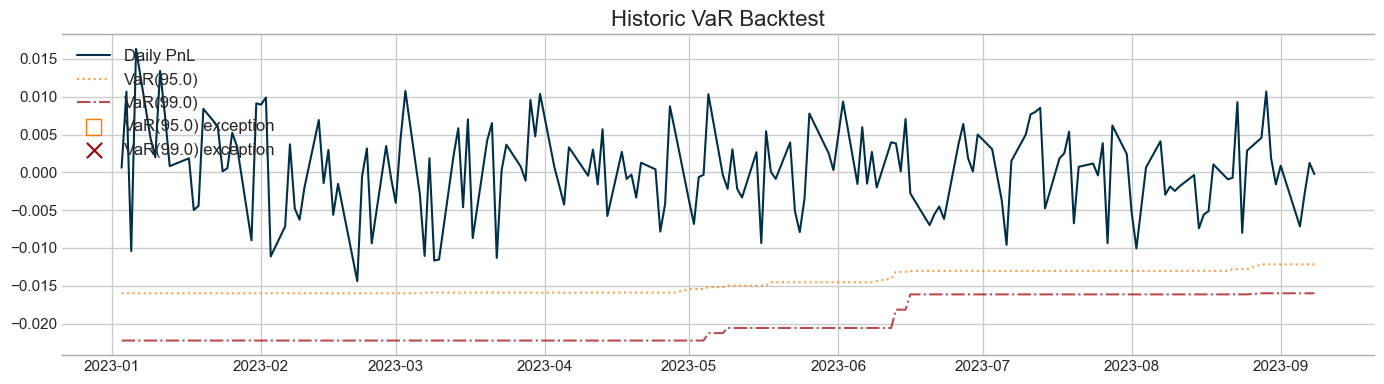

In [172]:
var.var_plot(bth)

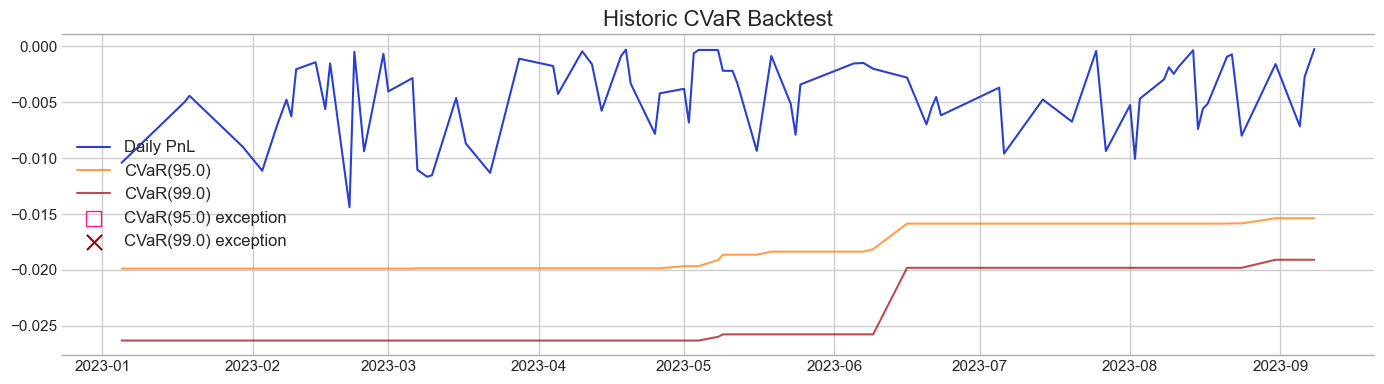

In [173]:
var.cvar_plot(bth)

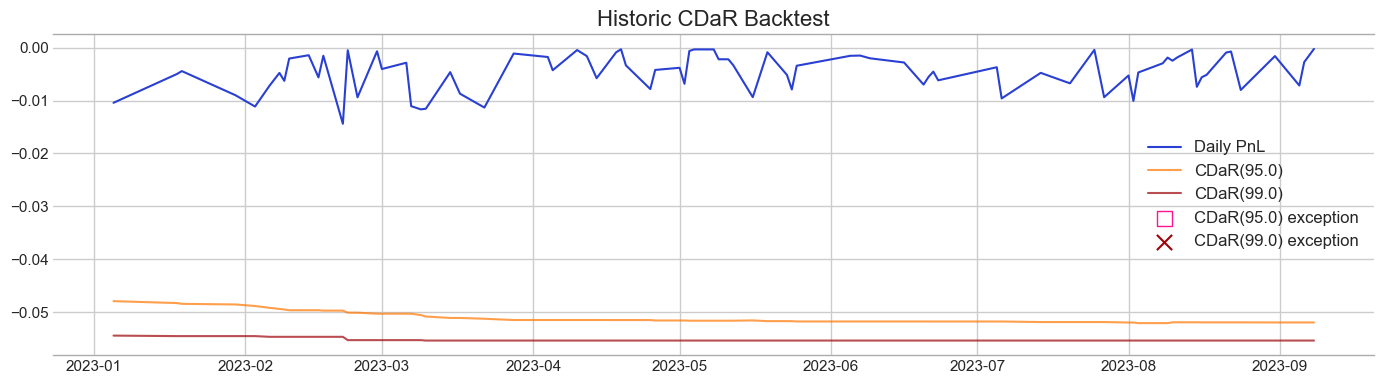

In [174]:
var.cdar_plot(bth)